In [1]:
import uproot
import awkward
import numpy as np
from scipy.sparse import csr_matrix
from scipy.spatial import cKDTree

from graph import SparseGraph, make_sparse_graph, save_graph, save_graphs, load_graph, load_graphs

fname = '../../samples/partGun_PDGid13_x2_E35.0To35.0_NTUP_1.root'
#fname = '../../samples/partGun_PDGid13_x1000_Pt3.0To100.0_NTUP_1.root'

test = uproot.open(fname)['ana']['hgc']

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

feature_names = ['x','y','layer','t','E']
n_features = len(feature_names)

#thanks Steve :-)
def draw_sample(X, Ri, Ro, cmap='bwr_r', alpha_labels=False,sim_list=None): # y,  # <--- y is edge weights
    # Select the i/o node features for each segment
    feats_o = X[Ro[:,1]]
    feats_i = X[Ri[:,1]]
    y = np.ones(min(feats_o.shape[0],feats_i.shape[0]))
    print('o',feats_o.shape)
    print('i',feats_i.shape)
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))#plt.figure()#
    #ax2 = fig.add_subplot(111, projection='3d')
    cmap = plt.get_cmap(cmap)
    
    if sim_list is None:    
        # Draw the hits (layer, x, y)
        ax0.scatter(X[:,0], X[:,2], c='k')
        ax1.scatter(X[:,1], X[:,2], c='k')
        #ax2.scatter(X[:,0], X[:,1], X[:,2], c='k')
    else:
        ax0.scatter(X[:,0], X[:,2], c='k')
        ax1.scatter(X[:,1], X[:,2], c='k')
        #ax2.scatter(X[:,0], X[:,1], X[:,2], c='k')
        ax0.scatter(X[sim_list,0], X[sim_list,2], c='b')
        ax1.scatter(X[sim_list,1], X[sim_list,2], c='b')
        #ax2.scatter(X[sim_list,0], X[sim_list,1], X[sim_list,2], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,0], feats_i[j,0]],
                 [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        #ax2.plot([feats_o[j,0], feats_i[j,0]],
        #         [feats_o[j,1], feats_i[j,1]],
        #         [feats_o[j,2], feats_i[j,2]],'-',**seg_args)
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()

In [3]:
#example of generating a binary ground-truth adjacency matrix 
#for both endcaps in all events for all clusters
#truth is now that hits in adjacent layers are connected 
#and so are hits in the same layer within delta-R < 2 
arrays = test.arrays([b'simcluster_hits_indices',b'rechit_x',b'rechit_y',
                      b'rechit_z',b'rechit_layer',b'rechit_time',b'rechit_energy'])
rechit_x = arrays[b'rechit_x']
rechit_y = arrays[b'rechit_y']
rechit_z = arrays[b'rechit_z']

#flip the x's of negative-endcap hits
#so it's all uniform in x,y,layer coordinates
rechit_x.content[rechit_z.content < 0] *= -1

rechit_time = arrays[b'rechit_time']
rechit_energy = arrays[b'rechit_energy']
rechit_layer = arrays[b'rechit_layer']
sim_indices = awkward.fromiter(arrays[b'simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]


def get_features(ievt,mask):
    x = rechit_x[ievt][mask]
    y = rechit_y[ievt][mask]
    layer = rechit_layer[ievt][mask]
    time = rechit_time[ievt][mask]
    energy = rechit_energy[ievt][mask]    
    return np.stack((x,y,layer,time,energy)).T
    
def make_graph_kdtree(coords,layers,r=2.5):
    the_tree = cKDTree(coords)
    R_i = the_tree.query_pairs(r=r,output_type='ndarray')
    
    row,col = R_i[:,0],R_i[:,1]
    
    R_i = R_i[np.abs(layers[(row,)]-layers[(col,)]) <= 1]
    
    R_o = np.stack((R_i[:,1],R_i[:,0])).T
    return R_i,R_o

def make_graph_numpy(ievt,rh_idx_map,in_row,in_col):
    row_layer = rechit_layer[ievt][in_row]
    col_layer = rechit_layer[ievt][in_col]
        
    row_x = rechit_x[ievt][in_row]
    col_x = rechit_x[ievt][in_col]
        
    row_y = rechit_y[ievt][in_row]
    col_y = rechit_y[ievt][in_col]

    other_layers_mask  = ( (np.abs(row_layer - col_layer) == 1) & 
                           (np.hypot(row_x - col_x,row_y - col_y) < 2.5)
                         )
    
    #here we define in-layer connections such that ~NNs talk to eachother
    #in-layer connections are bi-directional
    same_layer = ( (row_layer == col_layer) & 
                   (np.hypot(row_x - col_x,row_y - col_y) < 2.0) )
            
    row = rh_idx_map[in_row][other_layers_mask | same_layer]
    col = rh_idx_map[in_col][other_layers_mask | same_layer]
    return row,col


for ievt in range(rechit_z.size):

    #if ievt > 20: break
    
    pos_z_mask = (rechit_z[ievt] > 0)
    rh_pos_z, = np.where(pos_z_mask)
    rh_neg_z, = np.where(~pos_z_mask)
    rh_idx_map = np.zeros(pos_z_mask.size,dtype=np.int)
    rh_idx_map[pos_z_mask] = np.arange(rh_pos_z.size)
    rh_idx_map[~pos_z_mask] = np.arange(rh_neg_z.size)
        
    pos_feats = get_features(ievt,pos_z_mask)
    neg_feats = get_features(ievt,~pos_z_mask)
        
    pos_shape = (rh_pos_z.size,rh_pos_z.size)
    neg_shape = (rh_neg_z.size,rh_neg_z.size)
    
    adj_pos_z_fwd = csr_matrix(pos_shape,dtype=np.bool)
    adj_neg_z_fwd = csr_matrix(neg_shape,dtype=np.bool)
    
    adjidx_pos_z_fwd = np.ones(shape=(0,2),dtype=np.int)
    adjidx_neg_z_fwd = np.ones(shape=(0,2),dtype=np.int)
    
    adj_pos_z_bkw = csr_matrix(pos_shape,dtype=np.bool)
    adj_neg_z_bkw = csr_matrix(neg_shape,dtype=np.bool)
    
    adjidx_pos_z_bkw = np.ones(shape=(0,2),dtype=np.int)
    adjidx_neg_z_bkw = np.ones(shape=(0,2),dtype=np.int)
    
    distincts = valid_sim_indices[ievt].distincts()
    evt_pos_simhits = None
    evt_neg_simhits = None
    for iclu in range(distincts.size):        
        
        ispos = np.all(rechit_z[ievt][(valid_sim_indices[ievt][iclu],)] > 0)
        
        if valid_sim_indices[ievt][iclu].size < 3: continue
                
        sim_layers = rechit_layer[ievt][(valid_sim_indices[ievt][iclu],)]
        sim_pos_Ri,sim_pos_Ro = make_graph_kdtree(np.stack((rechit_x[ievt][(valid_sim_indices[ievt][iclu],)],
                                                            rechit_y[ievt][(valid_sim_indices[ievt][iclu],)],
                                                            rechit_layer[ievt][(valid_sim_indices[ievt][iclu],)])).T,
                                                  sim_layers,
                                                  2.4)
        
                
        row_fwd = rh_idx_map[(valid_sim_indices[ievt][iclu][(sim_pos_Ro[:,0],)],)]
        col_fwd = rh_idx_map[(valid_sim_indices[ievt][iclu][(sim_pos_Ro[:,1],)],)]
        
        row_bkw = col_fwd
        col_bkw = row_fwd        
        
        data_fwd = np.ones(row_fwd.size,dtype=np.bool)
        data_bkw = np.ones(row_bkw.size,dtype=np.bool)
        
        #clu_simhits = rh_idx_map[(valid_sim_indices[ievt][iclu],)].copy()
        
        if ispos:
            if evt_pos_simhits is None:
                evt_pos_simhits = rh_idx_map[(valid_sim_indices[ievt][iclu],)].copy()
            else:
                
                evt_pos_simhits = np.concatenate((evt_pos_simhits,rh_idx_map[(valid_sim_indices[ievt][iclu],)].copy()))
            
            mat_fwd = csr_matrix((data_fwd,(row_fwd,col_fwd)),shape=pos_shape,dtype=np.bool)
            adj_pos_z_fwd += mat_fwd
            mat_bkw = csr_matrix((data_bkw,(row_bkw,col_bkw)),shape=pos_shape,dtype=np.bool)
            adj_pos_z_bkw += mat_bkw
            
            if adjidx_pos_z_bkw is None:
                adjidx_pos_z_fwd = np.stack((row_fwd,col_fwd)).T
                adjidx_pos_z_bkw = np.stack((row_bkw,col_bkw)).T
            else:                
                adjidx_pos_z_fwd = np.concatenate((adjidx_pos_z_fwd,np.stack((row_fwd,col_fwd)).T))
                adjidx_pos_z_bkw = np.concatenate((adjidx_pos_z_bkw,np.stack((row_bkw,col_bkw)).T))
            
        else:
            if evt_neg_simhits is None:
                evt_neg_simhits = rh_idx_map[(valid_sim_indices[ievt][iclu],)].copy()
            else:
                evt_neg_simhits = np.concatenate((evt_neg_simhits,rh_idx_map[(valid_sim_indices[ievt][iclu],)].copy()))
            
            mat_fwd = csr_matrix((data_fwd,(row_fwd,col_fwd)),shape=neg_shape,dtype=np.bool)
            adj_neg_z_fwd += mat_fwd
            mat_bkw = csr_matrix((data_bkw,(row_bkw,col_bkw)),shape=neg_shape,dtype=np.bool)
            adj_neg_z_bkw += mat_bkw    
            
            if adjidx_neg_z_bkw is None:
                adjidx_neg_z_fwd = np.stack((row_fwd,col_fwd)).T
                adjidx_neg_z_bkw = np.stack((row_bkw,col_bkw)).T
            else:                
                adjidx_neg_z_fwd = np.concatenate((adjidx_neg_z_fwd,np.stack((row_fwd,col_fwd)).T))
                adjidx_neg_z_bkw = np.concatenate((adjidx_neg_z_bkw,np.stack((row_bkw,col_bkw)).T))                
    
    outbase = fname.split('/')[-1].replace('.root','')
    
    graph = SparseGraph(pos_feats,
                        adjidx_pos_z_bkw[:,0],adjidx_pos_z_bkw[:,1],
                        adjidx_pos_z_fwd[:,0],adjidx_pos_z_fwd[:,1],
                        np.ones(adjidx_pos_z_fwd.shape[0],dtype=np.bool),
                        evt_pos_simhits)
    save_graph(graph, '%s_hgcal_graph_pos_evt%d.npz'%(outbase,ievt))
        
    graph = SparseGraph(neg_feats,                            
                        adjidx_neg_z_bkw[:,0],adjidx_neg_z_bkw[:,1],
                        adjidx_neg_z_fwd[:,0],adjidx_neg_z_fwd[:,1],
                        np.ones(adjidx_pos_z_fwd.shape[0],dtype=np.bool),
                        evt_neg_simhits)
    save_graph(graph, '%s_hgcal_graph_neg_evt%d.npz'%(outbase,ievt))


o (80, 5)
i (80, 5)


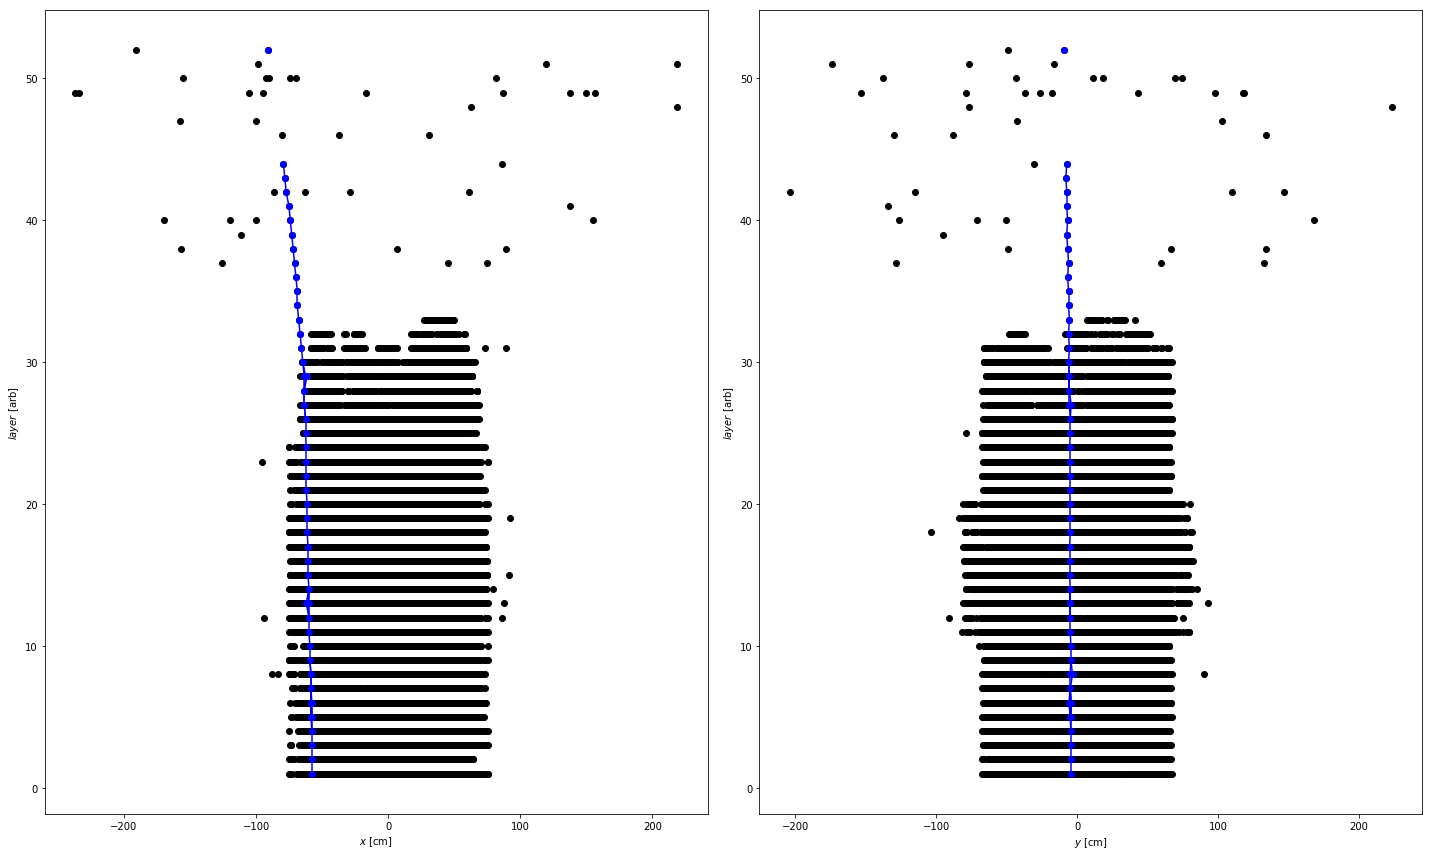

In [4]:
g1 = load_graph('partGun_PDGid13_x2_E35.0To35.0_NTUP_1_hgcal_graph_neg_evt0.npz')
#g1 = load_graph('partGun_PDGid13_x1000_Pt3.0To100.0_NTUP_1_hgcal_graph_neg_evt0.npz')

draw_sample(g1.X,
            np.stack((g1.Ri_rows,g1.Ri_cols)).T,
            np.stack((g1.Ro_rows,g1.Ro_cols)).T,
            sim_list=g1.simmatched)

o (44, 5)
i (44, 5)


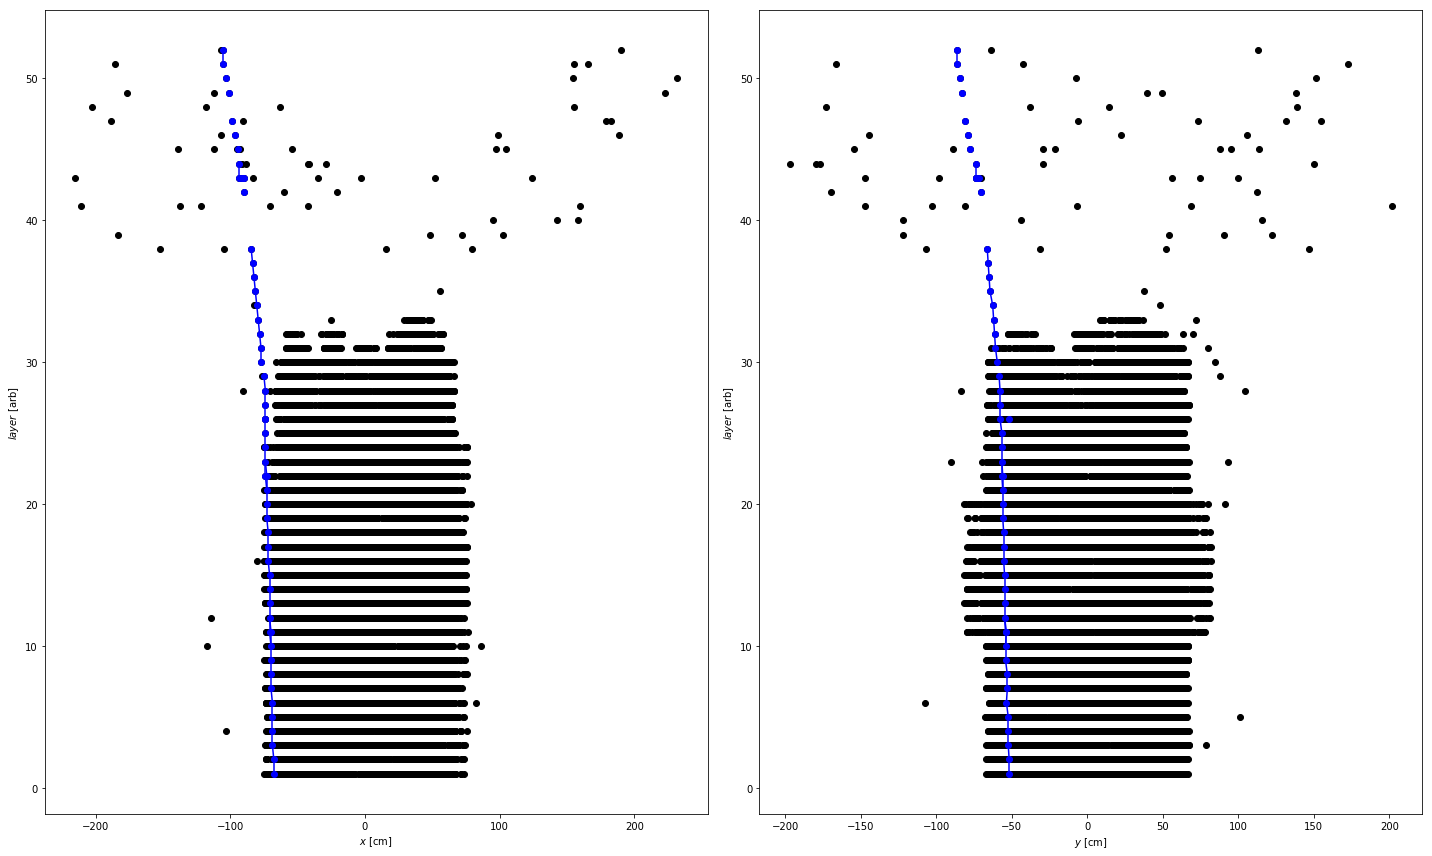

In [5]:
g2 = load_graph('partGun_PDGid13_x2_E35.0To35.0_NTUP_1_hgcal_graph_neg_evt1.npz')
#g2 = load_graph('partGun_PDGid13_x1000_Pt3.0To100.0_NTUP_1_hgcal_graph_neg_evt150.npz')

draw_sample(g2.X,
            np.stack((g2.Ri_rows,g2.Ri_cols)).T,
            np.stack((g2.Ro_rows,g2.Ro_cols)).T,
            sim_list=g2.simmatched)